In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, precision_recall_curve

import tensorflow as tf
import keras 

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, InputLayer, Flatten, Conv2D, MaxPooling2D

np.random.seed(42)
tf.random.set_seed(42)

from preprocessing.getdata import *

In [2]:
df_a = get_csvdata_ADNI(False)
df_o= get_csvdata(drop_young=False, drop_contradictions=False)

df_a_train, df_a_test, y_a_train, y_a_test = train_test_split(df_a['ID'], df_a['label'], stratify=df_a['label'], random_state=42)

df_o_train, df_o_test, y_o_train, y_o_test = train_test_split(df_o['ID'], df_o['label'], stratify=df_o['label'], random_state=42)

y_test = np.concatenate((y_o_test, y_a_test))

In [3]:
N = 0
d = 2
mdict = {0: 90, 1: 110, 2: 90}

def get_test(dim, N, d):
    m = mdict[dim]
    X_test_o = get_slices(df_o_test, dim=dim, m=m, N=N, d=d)
    X_test_a = get_slices_ADNI_new(df_a_test, dim=dim, m=m, N=N, d=d)

    X_test = np.concatenate((X_test_o, X_test_a), axis=0)

    X_test = np.repeat(X_test[..., np.newaxis], 3, -1)
    return X_test

X_test0 = get_test(0, N, d)
X_test1 = get_test(1, N, d)
X_test2 = get_test(2, N, d)

In [4]:
model0 = tf.keras.models.load_model('../models/axis00')
model1 = tf.keras.models.load_model('../models/axis01')
model2 = tf.keras.models.load_model('../models/axis02')

In [5]:
y_prob0 = model0.predict(X_test0)
y_prob1 = model1.predict(X_test1)
y_prob2 = model2.predict(X_test2)

10/10 [==============================] - 14s 1s/step


In [6]:
y_prob0 = y_prob0.reshape(len(df_o_test)+len(df_a_test),1+2*N)
y_prob1 = y_prob1.reshape(len(df_o_test)+len(df_a_test),1+2*N)
y_prob2 = y_prob2.reshape(len(df_o_test)+len(df_a_test),1+2*N)

In [6]:
y_prob0 = np.mean(y_prob0, axis=1)
y_prob1 = np.mean(y_prob1, axis=1)
y_prob2 = np.mean(y_prob2, axis=1)

In [8]:
y_test = y_test.repeat(1+2*N)

In [9]:
y_test.shape

(951,)

In [7]:
print('accuracy of axis 0: ', accuracy_score(y_test, y_prob0.round()))
print('accuracy of axis 1: ', accuracy_score(y_test, y_prob1.round()))
print('accuracy of axis 2: ', accuracy_score(y_test, y_prob2.round()))

accuracy of axis 0:  0.7634069400630915
accuracy of axis 1:  0.7728706624605678
accuracy of axis 2:  0.7665615141955836


In [8]:
y_prob = np.stack((y_prob0, y_prob1, y_prob2)).T

In [14]:
#y_pred = np.mean(y_prob, axis=1).round()
y_pred = np.mean(y_prob.round(), axis=1).round()

accuracy:  0.773
recall:  0.94
precision:  0.73


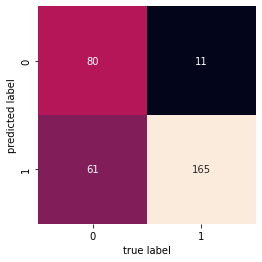

In [15]:
mat = confusion_matrix(y_test, y_pred.round())
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test, y_pred.round()).round(3))
print('recall: ' , recall_score(y_test, y_pred.round()).round(2))
print('precision: ' , precision_score(y_test, y_pred.round()).round(2))

In [18]:
mask = (y_test == 1) & (y_pred == 0)

In [44]:
mask = (y_test == 0) & (y_pred == 1)

In [46]:
mask = (y_test == 0) & (y_pred == 0)

In [53]:
mask0 = (y_pred == 1)
mask1 = (y_pred == 1)

In [36]:
mask = ((y_test == 0) & (y_pred == 1) |  (y_test == 1) & (y_pred == 0))

In [162]:
dff = pd.concat([pd.merge(df_o_test, df_o), pd.merge(df_a_test, df_a)])

In [163]:
dff['pred'] = y_pred

In [164]:
dffa = dff[dff['dataset']=='ADNI']
dffo = dff[dff['dataset']=='OASIS']

Text(91.68, 0.5, 'predicted label')

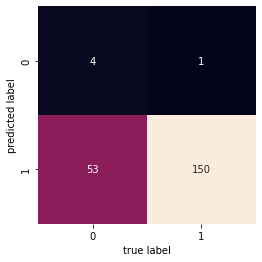

In [165]:
mat = confusion_matrix(dffa['label'], dffa['pred'])
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

Text(91.68, 0.5, 'predicted label')

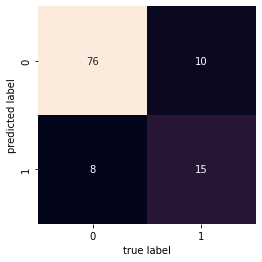

In [64]:
mat = confusion_matrix(dffo['label'], dffo['pred'])
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

<AxesSubplot:xlabel='Age', ylabel='pred'>

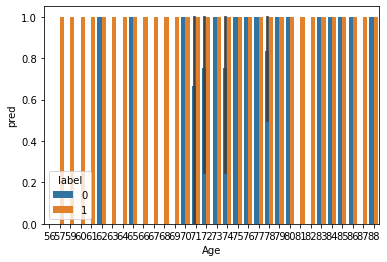

In [70]:
sns.barplot(data=dffa, x='Age', y='pred', hue='label')

In [60]:
dff.groupby(['dataset', 'label', 'pred']).count()['ID']

dataset  label  pred
ADNI     0      0.0       4
                1.0      53
         1      0.0       1
                1.0     150
OASIS    0      0.0      76
                1.0       8
         1      0.0      10
                1.0      15
Name: ID, dtype: int64

<AxesSubplot:xlabel='dataset', ylabel='label'>

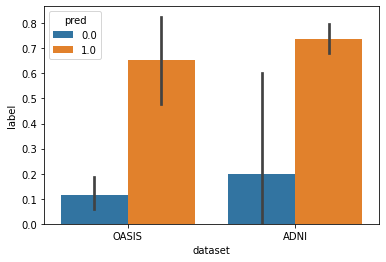

In [57]:
sns.barplot(data=dff,  x='dataset', y='label', hue='pred')

In [29]:
df = pd.concat([df_o, df_a])

In [33]:
df.groupby('Group').count()

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,...,dataset,Image Data ID,Sex,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
Group,,,,,,,,,,,,,,,,,,,,,
AD,198,0,198,0,0,0,0,0,0,0,...,198,198,198,198,198,198,198,198,198,198
CN,228,0,228,0,0,0,0,0,0,0,...,228,228,228,228,228,228,228,228,228,228
MCI,405,0,405,0,0,0,0,0,0,0,...,405,405,405,405,405,405,405,405,405,405


In [35]:
df.groupby('CDR_').count()

,ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,...,Image Data ID,Group,Sex,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
CDR_,,,,,,,,,,,,,,,,,,,,,
0.0,336,336,336,135,133,135,336,336,336,336,...,0,0,0,0,0,0,0,0,0,0
0.5,70,70,70,70,57,70,70,70,70,70,...,0,0,0,0,0,0,0,0,0,0
1.0,28,28,28,28,24,28,28,28,28,28,...,0,0,0,0,0,0,0,0,0,0
2.0,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0


In [74]:
dfa = pd.read_csv('../tadpole_challenge/ADNIMERGE.csv')

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py:3398: DtypeWarning: Columns (18,19,20,103,104) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [90]:
dfa[['PTID', 'CDRSB']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13915 entries, 0 to 13914
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PTID    13915 non-null  object 
 1   CDRSB   9984 non-null   float64
dtypes: float64(1), object(1)
memory usage: 217.5+ KB


In [101]:
df=pd.read_csv('../data/tadpole_challenge/ADNIMERGE.csv')

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py:3398: DtypeWarning: Columns (18,19,20,103,104) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [109]:
dfbl = df[df['VISCODE']=='bl']

In [134]:
dfbl = dfbl.rename({'PTID': 'ID'}, axis=1)

In [158]:
dfabl = df_a.merge(dfbl, on='ID')

In [141]:
dfabl.groupby(['Group', 'CDRSB']).count()

Image Data ID   ID  Sex  Age  Visit  Modality  Description  Type  \
Group CDRSB                                                                     
AD    1.0                1    1    1    1      1         1            1     1   
      1.5                9    9    9    9      9         9            9     9   
      2.0                7    7    7    7      7         7            7     7   
      2.5                6    6    6    6      6         6            6     6   
      3.0               21   21   21   21     21        21           21    21   
      3.5               23   23   23   23     23        23           23    23   
      4.0               25   25   25   25     25        25           25    25   
      4.5               29   29   29   29     29        29           29    29   
      5.0               25   25   25   25     25        25           25    25   
      5.5                7    7    7    7      7         7            7     7   
      6.0               13   13   13   13     13        13           13    13   
      6.5                4    4    4    4      4         4            4     4   
      7.0                7    7    7    7      7         7            7     7   
      8.0                7    7    7    7      7         7            7     7   
      9.0                3    3    3    3      3         3            3     3   
CN    0.0              212  212  212  212    212       212          212   212   
      0.5               14   14   14   14     14        14           14    14   
MCI   0.0                1    1    1    1      1         1            1     1   
      0.5               65   65   65   65     65        65           65    65   
      1.0               92   92   92   92     92        92           92    92   
      1.5               89   89   89   89     89        89           89    89   
      2.0               72   72   72   72     72        72           72    72   
      2.5               36   36   36   36     36        36           36    36   
      3.0               19   19   19   19     19        19           19    19   
      3.5               11   11   11   11     11        11           11    11   
      4.0                8    8    8    8      8         8            8     8   
      4.5                1    1    1    1      1         1            1     1   
      5.0                1    1    1    1      1         1            1     1   

             Acq Date  Format  ...  TAU_bl  PTAU_bl  FDG_bl  PIB_bl  AV45_bl  \
Group CDRSB                    ...                                             
AD    1.0           1       1  ...       1        1       1       0        0   
      1.5           9       9  ...       2        2       2       0        0   
      2.0           7       7  ...       6        6       4       0        0   
      2.5           6       6  ...       3        3       4       0        0   
      3.0          21      21  ...       7        7       5       0        0   
      3.5          23      23  ...      15       15      10       0        0   
      4.0          25      25  ...      17       17      10       1        0   
      4.5          29      29  ...      16       16      18       1        0   
      5.0          25      25  ...       9        9      19       2        0   
      5.5           7       7  ...       3        3       3       0        0   
      6.0          13      13  ...       7        7       7       0        0   
      6.5           4       4  ...       2        2       2       0        0   
      7.0           7       7  ...       4        4       4       0        0   
      8.0           7       7  ...       2        2       3       1        0   
      9.0           3       3  ...       2        2       3       0        0   
CN    0.0         212     212  ...     104      104      94       0        0   
      0.5          14      14  ...       6        6       8       0        0   
MCI   0.0           1       1  ...       0        0       0   

In [172]:
dfabl = dfabl.merge(dffa, on='ID')

In [177]:
dfabl.groupby(['pred_y','label','Group', 'CDRSB']).count()

ID  M/F_x  Age_x  Educ_x  SES_x  MMSE_x  CDR_x  \
pred_y label Group CDRSB                                                   
0.0    0     CN    0.0     4      0      4       0      0       0      0   
       1     MCI   2.0     1      0      1       0      0       0      0   
1.0    0     CN    0.0    49      0     49       0      0       0      0   
                   0.5     4      0      4       0      0       0      0   
       1     AD    1.5     2      0      2       0      0       0      0   
                   2.0     1      0      1       0      0       0      0   
                   2.5     1      0      1       0      0       0      0   
                   3.0     3      0      3       0      0       0      0   
                   3.5     6      0      6       0      0       0      0   
                   4.0     6      0      6       0      0       0      0   
                   4.5    10      0     10       0      0       0      0   
                   5.0     9      0      9       0      0       0      0   
                   5.5     1      0      1       0      0       0      0   
                   6.5     1      0      1       0      0       0      0   
                   7.0     2      0      2       0      0       0      0   
                   8.0     1      0      1       0      0       0      0   
                   9.0     2      0      2       0      0       0      0   
             MCI   0.5    18      0     18       0      0       0      0   
                   1.0    19      0     19       0      0       0      0   
                   1.5    30      0     30       0      0       0      0   
                   2.0    13      0     13       0      0       0      0   
                   2.5    15      0     15       0      0       0      0   
                   3.0     7      0      7       0      0       0      0   
                   3.5     1      0      1       0      0       0      0   

                          eTIV_x  nWBV_x  ASF_x  ...  dataset  Image Data ID  \
pred_y label Group CDRSB                         ...                           
0.0    0     CN    0.0         0       0      0  ...        4              4   
       1     MCI   2.0         0       0      0  ...        1              1   
1.0    0     CN    0.0         0       0      0  ...       49             49   
                   0.5         0       0      0  ...        4              4   
       1     AD    1.5         0       0      0  ...        2              2   
                   2.0         0       0      0  ...        1              1   
                   2.5         0       0      0  ...        1              1   
                   3.0         0       0      0  ...        3              3   
                   3.5         0       0      0  ...        6              6   
                   4.0         0       0      0  ...        6              6   
                   4.5         0       0      0  ...       10             10   
                   5.0         0       0      0  ...        9              9   
                   5.5         0       0      0  ...        1              1   
                   6.5         0       0      0  ...        1              1   
                   7.0         0       0      0  ...        2              2   
                   8.0         0       0      0  ...        1              1   
                   9.0         0       0      0  ...        2              2   
             MCI   0.5         0       0      0  ...       18             18   
                   1.0         0       0      0  ...       19             19   
                   1.5         0       0      0  ...       30             30   
                   2.0         0       0      0  ...       13             13   
                   2.5         0       0      0  ...       15             15   
                   3.0         0       0      0  ...        7              7   
                   3.5         0       0      0  

In [184]:
dfabl[(dfabl['label'] == 0) & (dfabl['pred_y'] == 1)].groupby('CDRSB').count()

,ID,M/F_x,Age_x,Educ_x,SES_x,MMSE_x,CDR_x,eTIV_x,nWBV_x,ASF_x,...,Group,Sex,Visit,Modality,Description,Type,Acq Date,Format,Downloaded,pred_y
CDRSB,,,,,,,,,,,,,,,,,,,,,
0.0,49,0,49,0,0,0,0,0,0,0,...,49,49,49,49,49,49,49,49,49,49
0.5,4,0,4,0,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4


In [190]:
df = pd.read_csv("../tadpole_challenge/ADNIMERGE.csv")
df.rename(columns={"PTID":"ID"}, inplace=True)


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\interactiveshell.py:3398: DtypeWarning: Columns (18,19,20,103,104) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [188]:
df

,RID,ID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,...,TAU_bl,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,011_S_0002,bl,11,ADNI1,ADNI1,2005-09-08,CN,74.3,Male,...,NaN,NaN,1.36665,NaN,NaN,0.000000,0.00000,0,0,2019-02-14 23:58:27.0
1,3,011_S_0003,bl,11,ADNI1,ADNI1,2005-09-12,AD,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,0.000000,0.00000,0,0,2019-02-14 23:58:27.0
2,3,011_S_0003,m06,11,ADNI1,ADNI1,2006-03-13,AD,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,0.498289,5.96721,6,6,2019-02-14 23:58:27.0
3,3,011_S_0003,m12,11,ADNI1,ADNI1,2006-09-12,AD,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,0.999316,11.96720,12,12,2019-02-14 23:58:27.0
4,3,011_S_0003,m24,11,ADNI1,ADNI1,2007-09-12,AD,81.3,Male,...,239.7,22.83,1.08355,NaN,NaN,1.998630,23.93440,24,24,2019-02-14 23:58:27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13910,4384,029_S_4384,m84,29,ADNI3,ADNI2,2019-04-09,CN,62.3,Male,...,109.3,9.86,1.12969,NaN,1.06225,7.167690,85.83610,84,84,2019-04-10 04:36:05.0
13911,6703,135_S_6703,bl,135,ADNI3,ADNI3,2019-04-09,NaN,62.7,Female,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,0,0,2019-04-10 04:36:10.0
13912,6145,014_S_6145,m12,14,ADNI3,ADNI3,2019-04-09,CN,70.3,Female,...,NaN,NaN,NaN,NaN,NaN,1.073240,12.85250,12,12,2019-04-11 04:36:24.0
13913,6148,014_S_6148,m12,14,ADNI3,ADNI3,2019-04-05,SMC,81.5,Female,...,NaN,NaN,NaN,NaN,NaN,1.081450,12.95080,12,12,2019-04-11 04:36:24.0


In [197]:
dfa = df[(df['Month']==0) & (df['COLPROT'] == "ADNI1")]
dfb = df[(df['VISCODE']=='bl') & (df['ORIGPROT']=='ADNI1')]

In [202]:
df_img=get_csvdata_ADNI(drop_MCI=False)

In [221]:
pd.merge(df_img, dfb, on='ID').groupby(['Group', 'DX', 'label', 'CDRSB']).count()

Image Data ID   ID  Sex  Age  Visit  Modality  \
Group DX       label CDRSB                                                  
AD    Dementia 1     1.0                1    1    1    1      1         1   
                     1.5                9    9    9    9      9         9   
                     2.0                7    7    7    7      7         7   
                     2.5                6    6    6    6      6         6   
                     3.0               21   21   21   21     21        21   
                     3.5               23   23   23   23     23        23   
                     4.0               24   24   24   24     24        24   
                     4.5               29   29   29   29     29        29   
                     5.0               25   25   25   25     25        25   
                     5.5                7    7    7    7      7         7   
                     6.0               13   13   13   13     13        13   
                     6.5                4    4    4    4      4         4   
                     7.0                7    7    7    7      7         7   
                     8.0                7    7    7    7      7         7   
                     9.0                3    3    3    3      3         3   
      MCI      1     4.0                1    1    1    1      1         1   
CN    CN       0     0.0              212  212  212  212    212       212   
                     0.5               14   14   14   14     14        14   
MCI   Dementia 1     1.5                1    1    1    1      1         1   
                     2.0                2    2    2    2      2         2   
                     2.5                1    1    1    1      1         1   
                     3.0                1    1    1    1      1         1   
      MCI      1     0.0                1    1    1    1      1         1   
                     0.5               65   65   65   65     65        65   
                     1.0               92   92   92   92     92        92   
                     1.5               88   88   88   88     88        88   
                     2.0               70   70   70   70     70        70   
                     2.5               35   35   35   35     35        35   
                     3.0               18   18   18   18     18        18   
                     3.5               11   11   11   11     11        11   
                     4.0                8    8    8    8      8         8   
                     4.5                1    1    1    1      1         1   
                     5.0                1    1    1    1      1         1   

                            Description  Type  Acq Date  Format  ...  TAU_bl  \
Group DX       label CDRSB                                       ...           
AD    Dementia 1     1.0              1     1         1       1  ...       1   
                     1.5              9     9         9       9  ...       2   
                     2.0              7     7         7       7  ...       6   
                     2.5              6     6         6       6  ...       3   
                     3.0             21    21        21      21  ...       7   
                     3.5             23    23        23      23  ...      15   
                     4.0             24    24        24      24  ...      16   
                     4.5             29    29        29      29  ...      16   
                     5.0             25    25        25      25  ...       9   
                     5.5              7     7         7       7  ...       3   
                     6.0             13    13        13      13  ...       7   
                     6.5              4     4         4       4  ...       2   
                     7.0              7     7         7       7  ...       4   
                     8.0              7     7         7       7  ...       2   
                     9.0              3     3       